In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
'''
Function definitions for the normal-inverse-gamma distribution. The parameters
of the distribution, namely mu, lambda / nu, alpha, beta, are as defined here:

  https://en.wikipedia.org/wiki/Normal-inverse-gamma_distribution

Note that we use the symbol nu (ν) rather than lambda (λ) for the third parameter.
This is to match the notation used in the conjugate priors table on Wikipedia:

  https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions
'''

def norminvgamma_pdf(x, sigma2, mu, nu, alpha, beta):
    '''
    The probability density function of the normal-inverse-gamma distribution at
    x (mean) and sigma2 (variance).
    '''
    return (
        stats.norm.pdf(x, loc=mu, scale=np.sqrt(sigma2 / nu)) *
        stats.invgamma.pdf(sigma2, a=alpha, scale=beta))

def norminvgamma_rvs(mu, nu, alpha, beta, size=1):
    '''
    Generate n samples from the normal-inverse-gamma distribution. This function
    returns a (size x 2) matrix where each row contains a sample, (x, sigma2).
    '''
    sigma2 = stats.invgamma.rvs(a=alpha, scale=beta, size=size)  # Sample sigma^2 from the inverse-gamma
    x = stats.norm.rvs(loc=mu, scale=np.sqrt(sigma2 / nu), size=size)  # Sample x from the normal
    return np.vstack((x, sigma2)).transpose()

In [3]:
# Use your pre-class work to enter values for your prior hyperparameters.
mu_0 = 2.3
nu_0 = 0.1
alpha_0 = 2
beta_0 = 5

In [4]:
# Load data: read the particle sizes (in nanometers) from a CSV file.
data = np.loadtxt('hrtem.csv')
print('%i data, min: %f, max: %f' % (len(data), min(data), max(data)))

500 data, min: 1.051827, max: 28.942578


## Task 1: Plot a histogram of the data.
Why does this histogram not look like a normal distribution?

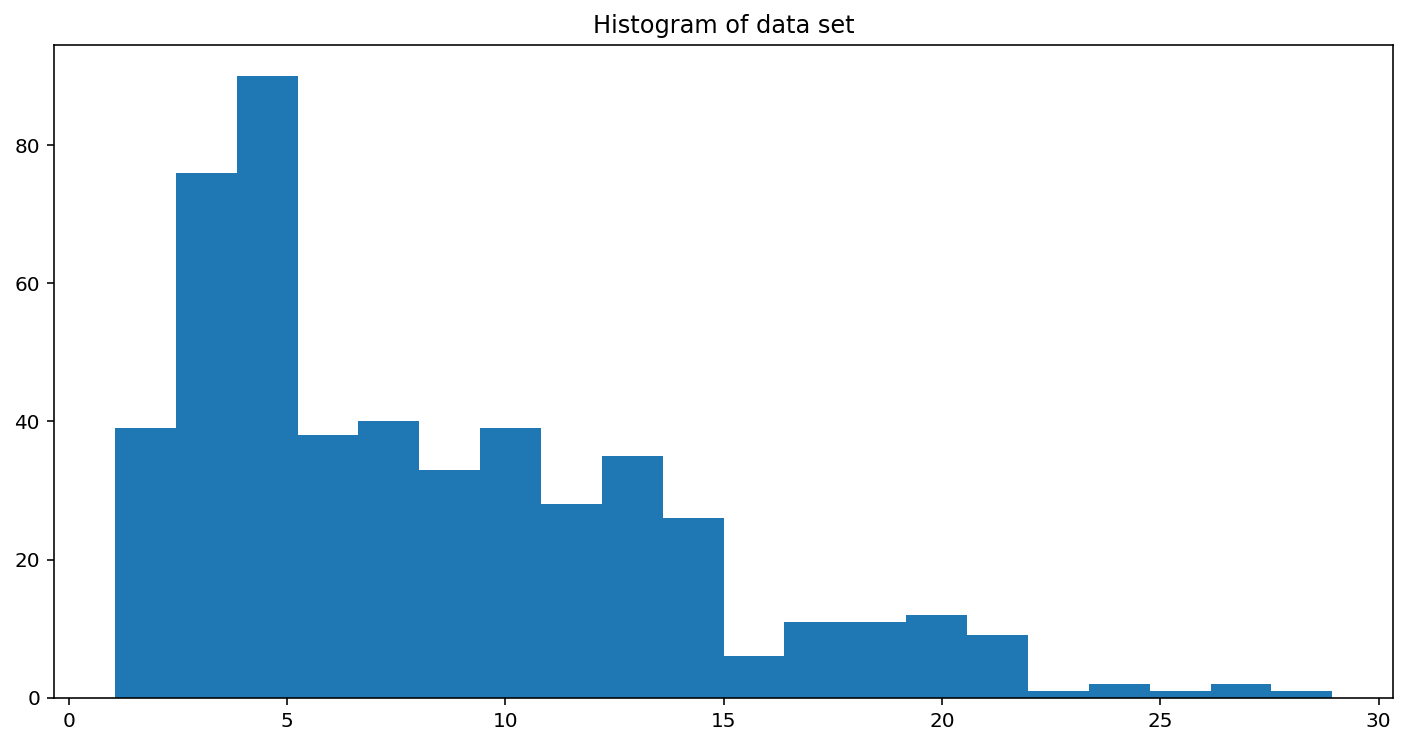

In [5]:
# Data are very skew and all values are positive, so probably non-normal.
plt.figure(figsize=(12,6))
plt.hist(data, bins=20)
plt.title('Histogram of data set')
plt.show()

## Task 2: Transform the data
Use the log function to transform the data and plot a histogram of the transformed data.

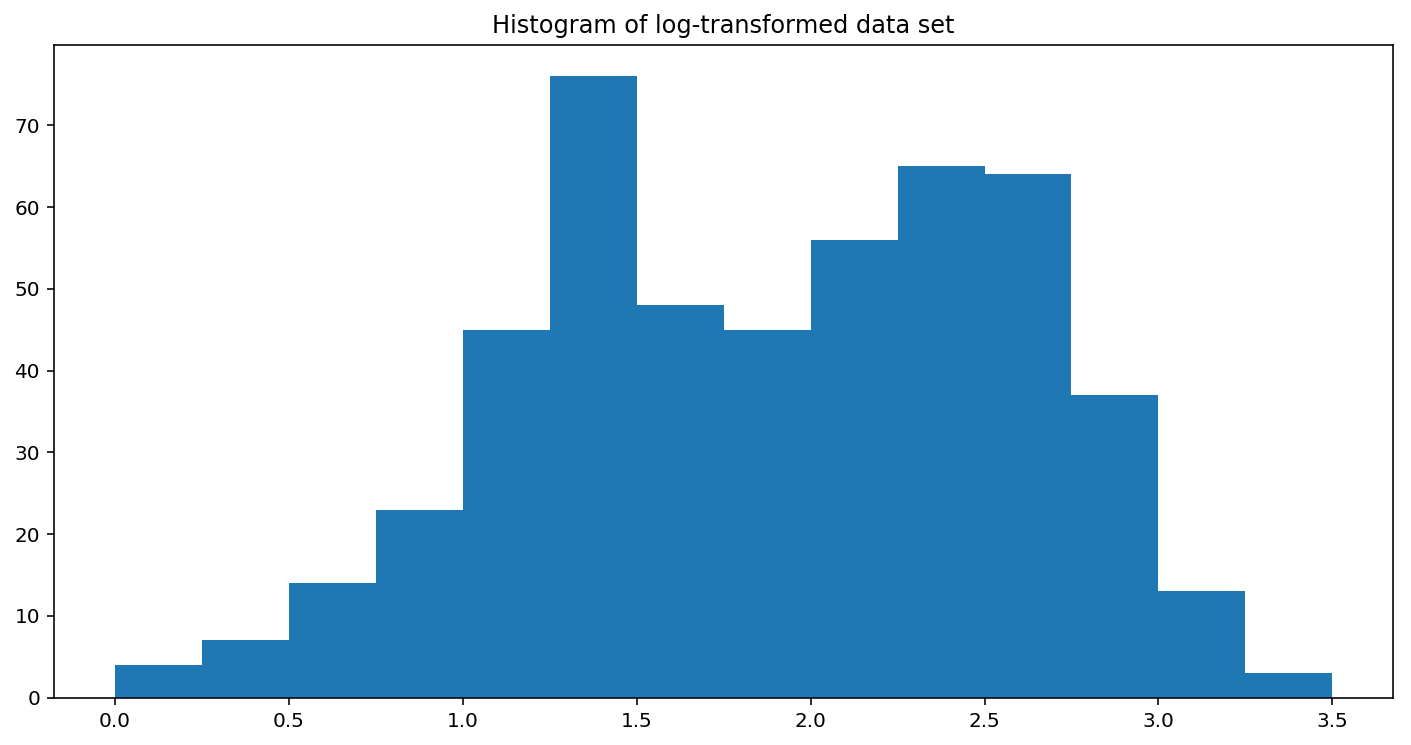

In [6]:
log_data = np.log(data)

# Data are very skew and all values are positive, so probably non-normal.
plt.figure(figsize=(12,6))
plt.hist(log_data, bins=np.linspace(0, 3.5, 15))
plt.title('Histogram of log-transformed data set')
plt.show()

## Task 3: Inference
Calculate **posterior** 95% confidence intervals over the mean and variance of the transformed data.

In [7]:
# Sufficient statistics of the data
s0 = len(log_data)
s1 = sum(log_data)
s2 = sum(log_data ** 2)

# Posterior parameters
mu_n = (nu_0 * mu_0 + s1) / (nu_0 + s0)
nu_n = nu_0 + s0
alpha_n = alpha_0 + s0 / 2
beta_n = beta_0 + s2/2 - s1**2 / (2*s0) + s0*nu_0/(nu_n + s0) * (s1/s0 - mu_0)**2/2

# Use samples from the posterior to approximate 95% confidence intervals
samples = norminvgamma_rvs(mu_n, nu_n, alpha_n, beta_n, size=1000000)
print('Mean 95%% confidence interval: [%.2f, %.2f]' % tuple(np.percentile(samples[:,0], [2.5, 97.5])))
print('Variance 95%% confidence interval: [%.2f, %.2f]' % tuple(np.percentile(samples[:,1], [2.5, 97.5])))

Mean 95% confidence interval: [1.83, 1.95]
Variance 95% confidence interval: [0.44, 0.56]


## Task 4: Visualize posterior normal pdf
The maximum of the normal-inverse-gamma pdf is given below. You can derive
this by setting to 0 the derivatives of the pdf with respect to its random
variables. This location is called the "maximum a posteriori" (MAP) value
of the random variables – literally meaning the mode of the posterior
distribution.

* Overlay the MAP **normal** pdf for on the histogram of the **transformed** data.

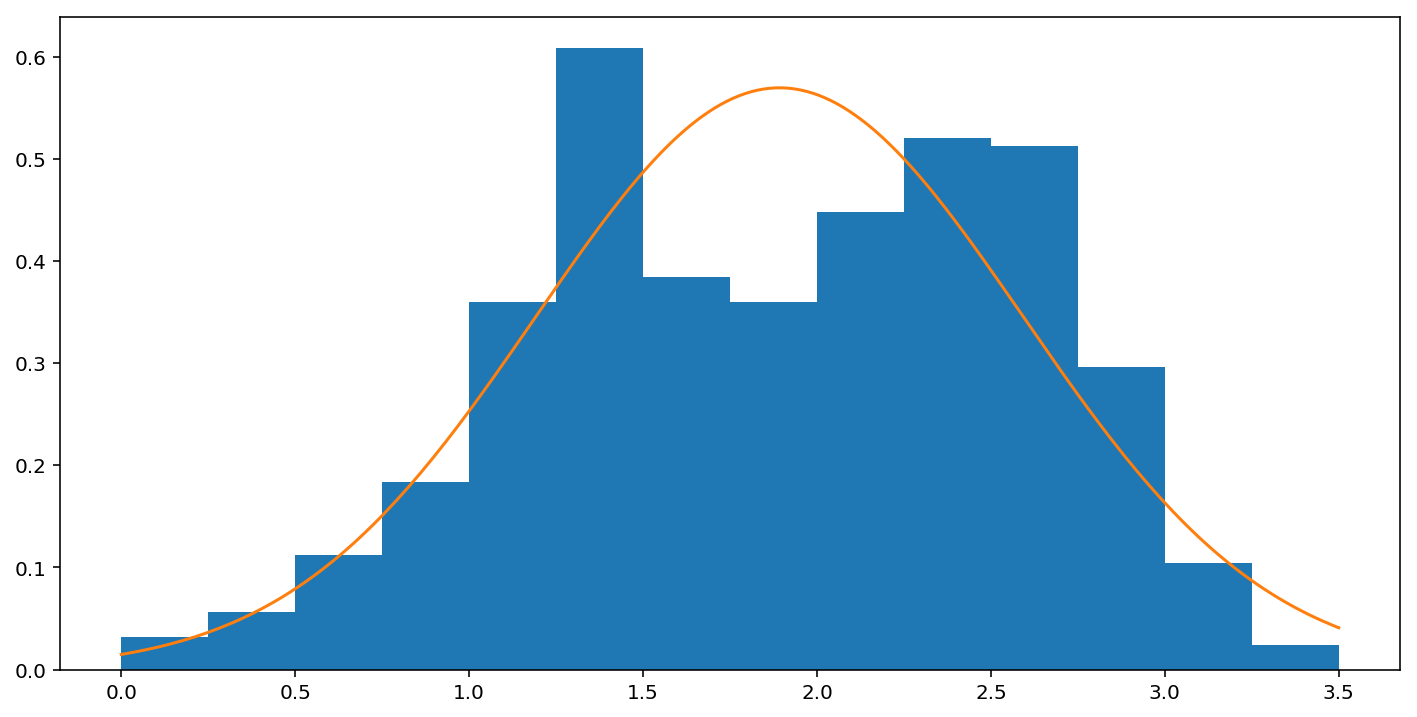

In [8]:
mean_map = mu_n  # maximum a posteriori mean
variance_map = beta_n / (alpha_n + 3/2)  # maximum a posteriori variance

plt.figure(figsize=(12,6))
plt.hist(log_data, bins=np.linspace(0, 3.5, 15), density=True)
plot_x = np.linspace(0, 3.5, 200)
plot_y = stats.norm.pdf(plot_x, loc=mean_map, scale=np.sqrt(variance_map))
plt.plot(plot_x, plot_y)
plt.show()

## Task 5: Visualize posterior log-normal pdf
Overlay the MAP **log-normal** pdf  on the histogram of the **original** data.

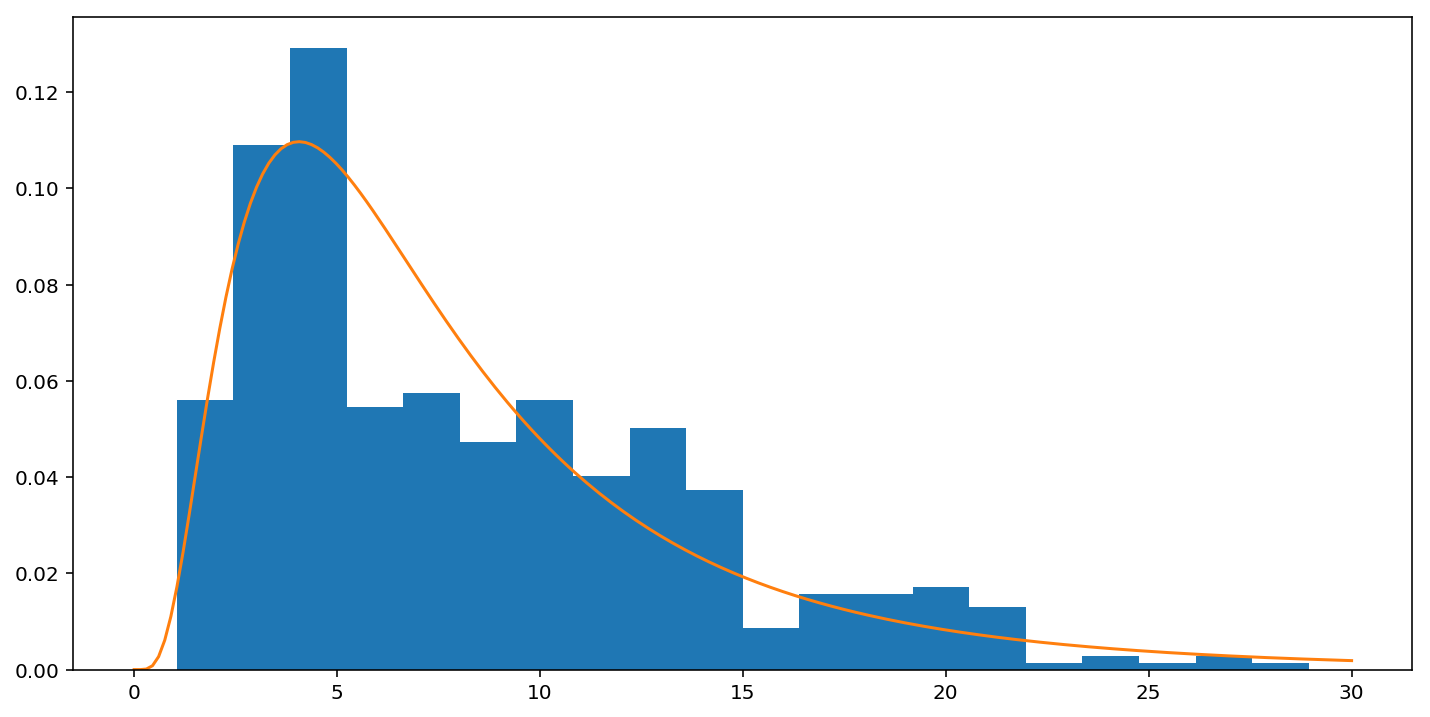

In [9]:
plt.figure(figsize=(12,6))
plt.hist(data, bins=20, density=True)
plot_x = np.linspace(0, 30, 200)
plot_y = stats.lognorm.pdf(plot_x, np.sqrt(variance_map), scale=np.exp(mean_map))
plt.plot(plot_x, plot_y)
plt.show()